**RESULTS SUMMARY** (remove after)

baseline cnn

best lr: 0.001, test = 95.19% (Kaggle: 0.95166)
scheduler: test = 96.28%

enhanced cnn

best lr: 0.001, test = 97.57% (Kaggle: 0.979)
scheduler: test = 98.38%

resnet

best lr: 0.005, test = 97.76% (Kaggle: 0.982)
scheduler: test = 98.42% (Kaggle: 0.98833)

# Data Exploration

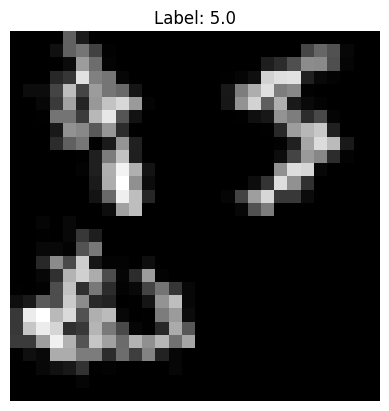

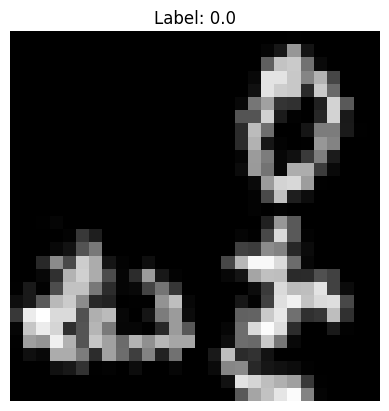

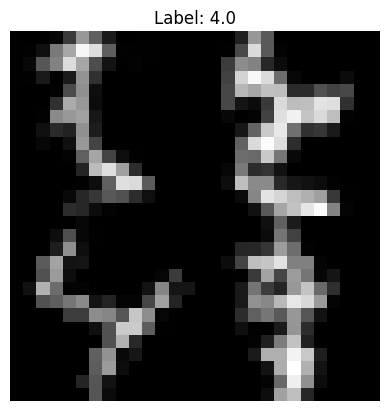

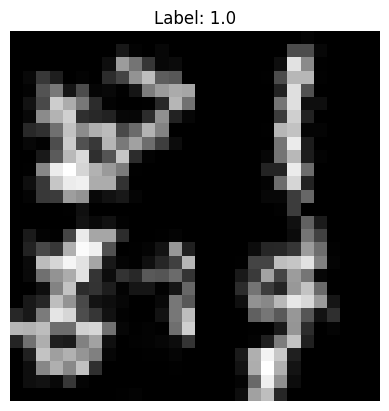

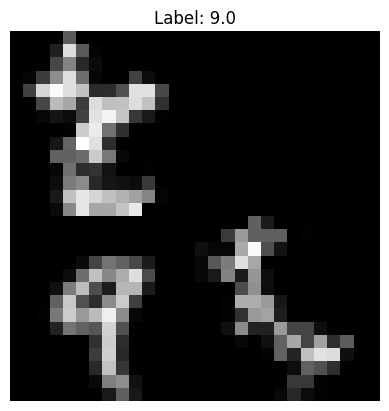

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Load labels from CSV
labels_df = pd.read_csv("Train_labels.csv", header=None)

# Load training data from pickle file
with open("Train.pkl", "rb") as f:
    train_data = pickle.load(f)

# Display first few images and their labels
for i in range(5):  # Display first 5 images
    plt.imshow(train_data[i].reshape((28, 28)), cmap='gray')  # Adjust cmap if needed
    plt.title(f"Label: {labels_df.iloc[i, 0]}")
    plt.axis("off")
    plt.show()

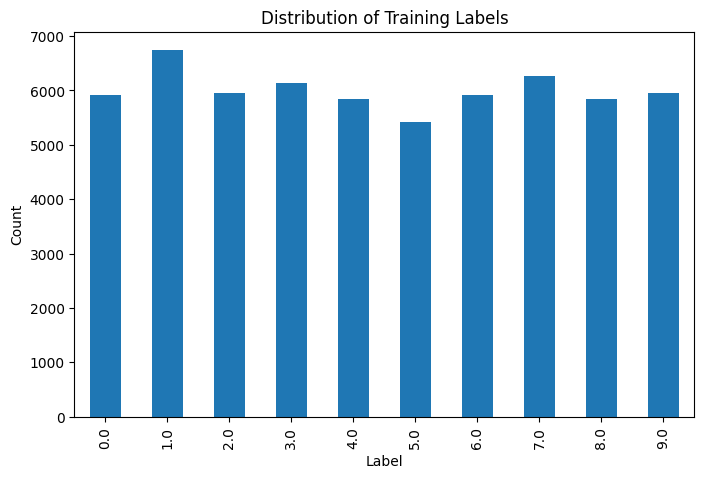

0
1.0    6742
7.0    6265
3.0    6131
2.0    5958
9.0    5949
0.0    5923
6.0    5918
8.0    5851
4.0    5842
5.0    5421
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(8, 5))
labels_df[0].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Training Labels")
plt.show()
print(labels_df[0].value_counts())

# Model 1: Baseline CNN

**Define Model**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # First convolutional layer
        # Input: 1x28x28, Output: 32x24x24
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0)
        # First pooling layer
        # Input: 32x24x24, Output: 32x12x12
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        # Input: 32x12x12, Output: 64x8x8
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0)
        # Second pooling layer
        # Input: 64x8x8, Output: 64x4x4
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        # Second conv block
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten
        x = x.view(-1, 64 * 4 * 4)

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

**Normal Training**

In [ ]:
import torch
import torch.utils.data as data
import pandas as pd
import pickle
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch accuracy and loss
    epoch_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Save trained model
torch.save(model.state_dict(), "cnn_model.pth")


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/10, Loss: 1.4840, Accuracy: 46.80%
Epoch 2/10, Loss: 0.7207, Accuracy: 75.70%
Epoch 3/10, Loss: 0.4990, Accuracy: 83.95%
Epoch 4/10, Loss: 0.3793, Accuracy: 88.01%
Epoch 5/10, Loss: 0.3209, Accuracy: 89.85%
Epoch 6/10, Loss: 0.2800, Accuracy: 91.34%
Epoch 7/10, Loss: 0.2533, Accuracy: 92.10%
Epoch 8/10, Loss: 0.2317, Accuracy: 92.79%
Epoch 9/10, Loss: 0.2144, Accuracy: 93.28%
Epoch 10/10, Loss: 0.2025, Accuracy: 93.61%
Test Accuracy: 93.06%


**Train with different learning rates**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Train Models with Different LRs ---
learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = CNN(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    val_accuracies = []

    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate epoch accuracy and loss
        epoch_accuracy = 100 * correct_train / total_train
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

        results[lr] = {
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

    torch.save(model.state_dict(), f"cnn_lr_{lr}.pth")

Training with learning rate: 0.05
Epoch 1/10, Loss: 2.5798, Accuracy: 10.65%
Epoch 2/10, Loss: 2.3057, Accuracy: 10.44%
Epoch 3/10, Loss: 2.3047, Accuracy: 10.60%
Epoch 4/10, Loss: 2.3054, Accuracy: 10.71%
Epoch 5/10, Loss: 2.3059, Accuracy: 10.37%
Epoch 6/10, Loss: 2.3057, Accuracy: 10.64%
Epoch 7/10, Loss: 2.3050, Accuracy: 10.56%
Epoch 8/10, Loss: 2.3054, Accuracy: 10.61%
Epoch 9/10, Loss: 2.3053, Accuracy: 10.54%
Epoch 10/10, Loss: 2.3053, Accuracy: 10.60%
Final Test Accuracy: 9.79%
Training with learning rate: 0.01
Epoch 1/10, Loss: 2.3030, Accuracy: 11.04%
Epoch 2/10, Loss: 2.3019, Accuracy: 11.15%
Epoch 3/10, Loss: 2.3020, Accuracy: 11.19%
Epoch 4/10, Loss: 2.3020, Accuracy: 11.20%
Epoch 5/10, Loss: 2.3021, Accuracy: 11.16%
Epoch 6/10, Loss: 2.3021, Accuracy: 11.07%
Epoch 7/10, Loss: 2.3019, Accuracy: 11.16%
Epoch 8/10, Loss: 2.3020, Accuracy: 11.12%
Epoch 9/10, Loss: 2.3021, Accuracy: 11.14%
Epoch 10/10, Loss: 2.3020, Accuracy: 11.21%
Final Test Accuracy: 11.00%
Training with l

**Optimized training with LR scheduler**



In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Increased batch size for faster training
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the EnhancedCNN model
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

# Set to 15 epochs
epochs = 15

# Using AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler for faster convergence - adjusted for 15 epochs
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=epochs
)

# Training loop with 15 epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Step the scheduler

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch accuracy and loss
    epoch_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")

    # Optional: Evaluate on test set after each 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_accuracy = 100 * test_correct / test_total
        print(f"Test Accuracy at Epoch {epoch+1}: {test_accuracy:.2f}%")
        model.train()  # Switch back to training mode

# Save trained model
torch.save(model.state_dict(), "enhanced_cnn_model_15epochs.pth")

# Final Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

Using device: cuda
Epoch 1/15, Loss: 1.7728, Accuracy: 36.29%, LR: 0.001524
Epoch 2/15, Loss: 0.6869, Accuracy: 77.01%, LR: 0.004370
Epoch 3/15, Loss: 0.3117, Accuracy: 90.44%, LR: 0.007605
Epoch 4/15, Loss: 0.2263, Accuracy: 93.35%, LR: 0.009713
Epoch 5/15, Loss: 0.1965, Accuracy: 94.39%, LR: 0.009944
Test Accuracy at Epoch 5: 93.14%
Epoch 6/15, Loss: 0.1889, Accuracy: 94.53%, LR: 0.009503
Epoch 7/15, Loss: 0.1580, Accuracy: 95.48%, LR: 0.008663
Epoch 8/15, Loss: 0.1350, Accuracy: 96.12%, LR: 0.007497
Epoch 9/15, Loss: 0.1171, Accuracy: 96.69%, LR: 0.006109
Epoch 10/15, Loss: 0.0942, Accuracy: 97.11%, LR: 0.004622
Test Accuracy at Epoch 10: 95.94%
Epoch 11/15, Loss: 0.0683, Accuracy: 98.00%, LR: 0.003170
Epoch 12/15, Loss: 0.0483, Accuracy: 98.46%, LR: 0.001879
Epoch 13/15, Loss: 0.0335, Accuracy: 98.94%, LR: 0.000867
Epoch 14/15, Loss: 0.0240, Accuracy: 99.26%, LR: 0.000221
Epoch 15/15, Loss: 0.0203, Accuracy: 99.40%, LR: 0.000000
Test Accuracy at Epoch 15: 96.28%
Final Test Accuracy

**Save Predictions**

In [ ]:
# Load test data
with open("Test.pkl", "rb") as f:
    test_images = pickle.load(f)


class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.astype('float32')  # Ensure image is float32 for normalization
        return image


test_dataset = ImageDataset(test_images)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.load_state_dict(torch.load("enhanced_cnn_model_15epochs.pth"))
model.eval()  # Set the model to evaluation mode

# Make predictions on the test dataset
predictions = []
ids = []

with torch.no_grad():
    for idx, images in enumerate(test_loader):
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        batch_size = images.size(0)
        start_id = idx * 64 + 1  # IDs start from 1
        for i in range(batch_size):
            ids.append(start_id + i)
            predictions.append(predicted[i].item())

# Create a DataFrame with 'id' and 'label' columns
df = pd.DataFrame({
    'id': ids,
    'class': predictions
})

# Save the predictions to a CSV file
df.to_csv('predictions1.csv', index=False)
print("Predictions saved to 'predictions1.csv'")

<ipython-input-41-29815f405276>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("enhanced_cnn_model_15epochs.pth"))


Predictions saved to 'predictions1.csv'


# Model 2: Optimized CNN

**Define Model**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

**Normal training**

In [ ]:
import torch
import torch.utils.data as data
import pandas as pd
import pickle
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch accuracy and loss
    epoch_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Save trained model
torch.save(model.state_dict(), "cnn_model.pth")


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/10, Loss: 0.5972, Accuracy: 80.35%
Epoch 2/10, Loss: 0.2269, Accuracy: 92.78%
Epoch 3/10, Loss: 0.1708, Accuracy: 94.52%
Epoch 4/10, Loss: 0.1386, Accuracy: 95.63%
Epoch 5/10, Loss: 0.1186, Accuracy: 96.25%
Epoch 6/10, Loss: 0.1060, Accuracy: 96.64%
Epoch 7/10, Loss: 0.0922, Accuracy: 96.98%
Epoch 8/10, Loss: 0.0832, Accuracy: 97.28%
Epoch 9/10, Loss: 0.0702, Accuracy: 97.69%
Epoch 10/10, Loss: 0.0669, Accuracy: 97.77%
Test Accuracy: 97.37%


**Train with different learning rates**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Train Models with Different LRs ---
learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = EnhancedCNN(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    val_accuracies = []

    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate epoch accuracy and loss
        epoch_accuracy = 100 * correct_train / total_train
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

        results[lr] = {
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

    torch.save(model.state_dict(), f"cnn_lr_{lr}.pth")

Training with learning rate: 0.05
Epoch 1/10, Loss: 1.1454, Accuracy: 63.19%
Epoch 2/10, Loss: 0.4616, Accuracy: 86.46%
Epoch 3/10, Loss: 0.3759, Accuracy: 89.14%
Epoch 4/10, Loss: 0.3312, Accuracy: 90.66%
Epoch 5/10, Loss: 0.2970, Accuracy: 91.57%
Epoch 6/10, Loss: 0.2862, Accuracy: 91.99%
Epoch 7/10, Loss: 0.2634, Accuracy: 92.72%
Epoch 8/10, Loss: 0.2511, Accuracy: 93.00%
Epoch 9/10, Loss: 0.2429, Accuracy: 93.34%
Epoch 10/10, Loss: 0.2272, Accuracy: 93.68%
Final Test Accuracy: 96.42%
Training with learning rate: 0.01
Epoch 1/10, Loss: 0.6294, Accuracy: 79.44%
Epoch 2/10, Loss: 0.2360, Accuracy: 92.91%
Epoch 3/10, Loss: 0.1852, Accuracy: 94.39%
Epoch 4/10, Loss: 0.1635, Accuracy: 95.11%
Epoch 5/10, Loss: 0.1475, Accuracy: 95.58%
Epoch 6/10, Loss: 0.1309, Accuracy: 96.12%
Epoch 7/10, Loss: 0.1253, Accuracy: 96.29%
Epoch 8/10, Loss: 0.1206, Accuracy: 96.36%
Epoch 9/10, Loss: 0.1075, Accuracy: 96.79%
Epoch 10/10, Loss: 0.1025, Accuracy: 96.97%
Final Test Accuracy: 97.20%
Training with 

**Optimized training parameters for EnhancedCNN**



In [ ]:
# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Increased batch size for faster training
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the EnhancedCNN model
model = EnhancedCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

# Using AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler for faster convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=10
)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(images)

        # The model outputs log_softmax, so we need to use NLLLoss instead of CrossEntropyLoss
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Step the scheduler

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch accuracy and loss
    epoch_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")

# Save trained model
torch.save(model.state_dict(), "enhanced_cnn_model.pth")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Using device: cuda
Epoch 1/10, Loss: 0.7994, Accuracy: 73.52%, LR: 0.002804
Epoch 2/10, Loss: 0.3014, Accuracy: 90.51%, LR: 0.007608
Epoch 3/10, Loss: 0.2191, Accuracy: 93.29%, LR: 0.010000
Epoch 4/10, Loss: 0.1628, Accuracy: 95.06%, LR: 0.009502
Epoch 5/10, Loss: 0.1297, Accuracy: 95.98%, LR: 0.008113
Epoch 6/10, Loss: 0.0988, Accuracy: 96.93%, LR: 0.006107
Epoch 7/10, Loss: 0.0697, Accuracy: 97.67%, LR: 0.003882
Epoch 8/10, Loss: 0.0473, Accuracy: 98.49%, LR: 0.001878
Epoch 9/10, Loss: 0.0320, Accuracy: 98.92%, LR: 0.000493
Epoch 10/10, Loss: 0.0228, Accuracy: 99.27%, LR: 0.000000
Test Accuracy: 98.03%


**Optimized training with LR scheduler**

In [ ]:
# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Increased batch size for faster training
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the EnhancedCNN model
model = EnhancedCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

# Set to 15 epochs
epochs = 15

# Using AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler for faster convergence - adjusted for 15 epochs
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=epochs
)

# Training loop with 15 epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(images)

        # The model outputs log_softmax, so we need to use NLLLoss
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Step the scheduler

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch accuracy and loss
    epoch_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")

    # Optional: Evaluate on test set after each 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_accuracy = 100 * test_correct / test_total
        print(f"Test Accuracy at Epoch {epoch+1}: {test_accuracy:.2f}%")
        model.train()  # Switch back to training mode

# Save trained model
torch.save(model.state_dict(), "enhanced_cnn_model_15epochs.pth")

# Final Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

Using device: cuda
Epoch 1/15, Loss: 0.8162, Accuracy: 73.10%, LR: 0.001524
Epoch 2/15, Loss: 0.3018, Accuracy: 90.48%, LR: 0.004370
Epoch 3/15, Loss: 0.2373, Accuracy: 92.55%, LR: 0.007605
Epoch 4/15, Loss: 0.1902, Accuracy: 94.13%, LR: 0.009713
Epoch 5/15, Loss: 0.1564, Accuracy: 95.27%, LR: 0.009944
Test Accuracy at Epoch 5: 96.30%
Epoch 6/15, Loss: 0.1312, Accuracy: 95.87%, LR: 0.009503
Epoch 7/15, Loss: 0.1107, Accuracy: 96.62%, LR: 0.008663
Epoch 8/15, Loss: 0.0883, Accuracy: 97.25%, LR: 0.007497
Epoch 9/15, Loss: 0.0757, Accuracy: 97.54%, LR: 0.006109
Epoch 10/15, Loss: 0.0611, Accuracy: 98.08%, LR: 0.004622
Test Accuracy at Epoch 10: 97.75%
Epoch 11/15, Loss: 0.0430, Accuracy: 98.57%, LR: 0.003170
Epoch 12/15, Loss: 0.0300, Accuracy: 99.00%, LR: 0.001879
Epoch 13/15, Loss: 0.0201, Accuracy: 99.35%, LR: 0.000867
Epoch 14/15, Loss: 0.0147, Accuracy: 99.53%, LR: 0.000221
Epoch 15/15, Loss: 0.0120, Accuracy: 99.63%, LR: 0.000000
Test Accuracy at Epoch 15: 98.38%
Final Test Accuracy

**Save Predictions**

In [ ]:
# Load test data
with open("Test.pkl", "rb") as f:
    test_images = pickle.load(f)


class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.astype('float32')  # Ensure image is float32 for normalization
        return image


test_dataset = ImageDataset(test_images)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.load_state_dict(torch.load("enhanced_cnn_model_15epochs.pth"))
model.eval()  # Set the model to evaluation mode

# Make predictions on the test dataset
predictions = []
ids = []

with torch.no_grad():
    for idx, images in enumerate(test_loader):
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        batch_size = images.size(0)
        start_id = idx * 64 + 1  # IDs start from 1
        for i in range(batch_size):
            ids.append(start_id + i)
            predictions.append(predicted[i].item())

# Create a DataFrame with 'id' and 'label' columns
df = pd.DataFrame({
    'id': ids,
    'class': predictions
})

# Save the predictions to a CSV file
df.to_csv('predictions1.csv', index=False)
print("Predictions saved to 'predictions1.csv'")

<ipython-input-41-29815f405276>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("enhanced_cnn_model_15epochs.pth"))


Predictions saved to 'predictions1.csv'


In [ ]:
# Load test data
with open("Test.pkl", "rb") as f:
    test_images = pickle.load(f)


class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.astype('float32')  # Ensure image is float32 for normalization
        return image


test_dataset = ImageDataset(test_images)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.load_state_dict(torch.load("cnn_model.pth"))
model.eval()  # Set the model to evaluation mode

# Make predictions on the test dataset
predictions = []
ids = []

with torch.no_grad():
    for idx, images in enumerate(test_loader):
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        batch_size = images.size(0)
        start_id = idx * 64 + 1  # IDs start from 1
        for i in range(batch_size):
            ids.append(start_id + i)
            predictions.append(predicted[i].item())

# Create a DataFrame with 'id' and 'label' columns
df = pd.DataFrame({
    'id': ids,
    'class': predictions
})

# Save the predictions to a CSV file
df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'


# Model 3: ResNet

**Define Model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out


class ResNet18CNN(nn.Module):
    def __init__(self, num_classes=10):
        nn.Module.__init__(self)

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1,stride=stride, bias=False), nn.BatchNorm2d(out_channels))

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

**Train with different learning rates**

In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# --- Train Models with Different LRs ---
learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = ResNet18CNN(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    val_accuracies = []

    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate epoch accuracy and loss
        epoch_accuracy = 100 * correct_train / total_train
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

        results[lr] = {
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

    torch.save(model.state_dict(), f"cnn_lr_{lr}.pth")

Training with learning rate: 0.05
Epoch 1/10, Loss: 1.3047, Accuracy: 55.49%
Epoch 2/10, Loss: 0.2199, Accuracy: 93.24%
Epoch 3/10, Loss: 0.1618, Accuracy: 95.00%
Epoch 4/10, Loss: 0.1315, Accuracy: 96.00%
Epoch 5/10, Loss: 0.1138, Accuracy: 96.56%
Epoch 6/10, Loss: 0.0985, Accuracy: 97.03%
Epoch 7/10, Loss: 0.0905, Accuracy: 97.21%
Epoch 8/10, Loss: 0.0814, Accuracy: 97.52%
Epoch 9/10, Loss: 0.0736, Accuracy: 97.72%
Epoch 10/10, Loss: 0.0659, Accuracy: 97.95%
Final Test Accuracy: 96.18%
Training with learning rate: 0.01
Epoch 1/10, Loss: 0.8906, Accuracy: 69.49%
Epoch 2/10, Loss: 0.1841, Accuracy: 94.49%
Epoch 3/10, Loss: 0.1322, Accuracy: 96.01%
Epoch 4/10, Loss: 0.1085, Accuracy: 96.70%
Epoch 5/10, Loss: 0.0887, Accuracy: 97.25%
Epoch 6/10, Loss: 0.0779, Accuracy: 97.56%
Epoch 7/10, Loss: 0.0660, Accuracy: 97.86%
Epoch 8/10, Loss: 0.0553, Accuracy: 98.20%
Epoch 9/10, Loss: 0.0509, Accuracy: 98.36%
Epoch 10/10, Loss: 0.0444, Accuracy: 98.60%
Final Test Accuracy: 96.51%
Training with 

**Optimized training with LR scheduler**



In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Increased batch size for faster training
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the EnhancedCNN model
model = ResNet18CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

# Set to 15 epochs
epochs = 15

# Using AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler for faster convergence - adjusted for 15 epochs
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=epochs
)

# Training loop with 15 epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Step the scheduler

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch accuracy and loss
    epoch_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")

    # Optional: Evaluate on test set after each 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_accuracy = 100 * test_correct / test_total
        print(f"Test Accuracy at Epoch {epoch+1}: {test_accuracy:.2f}%")
        model.train()  # Switch back to training mode

# Save trained model
torch.save(model.state_dict(), "enhanced_cnn_model_15epochs.pth")

# Final Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

Using device: cuda
Epoch 1/15, Loss: 0.4761, Accuracy: 84.28%, LR: 0.001524
Epoch 2/15, Loss: 0.1983, Accuracy: 94.06%, LR: 0.004370
Epoch 3/15, Loss: 0.1643, Accuracy: 95.16%, LR: 0.007605
Epoch 4/15, Loss: 0.1300, Accuracy: 96.17%, LR: 0.009713
Epoch 5/15, Loss: 0.0960, Accuracy: 97.15%, LR: 0.009944
Test Accuracy at Epoch 5: 96.21%
Epoch 6/15, Loss: 0.0717, Accuracy: 97.89%, LR: 0.009503
Epoch 7/15, Loss: 0.0597, Accuracy: 98.17%, LR: 0.008663
Epoch 8/15, Loss: 0.0434, Accuracy: 98.65%, LR: 0.007497
Epoch 9/15, Loss: 0.0322, Accuracy: 99.00%, LR: 0.006109
Epoch 10/15, Loss: 0.0204, Accuracy: 99.30%, LR: 0.004622
Test Accuracy at Epoch 10: 97.55%
Epoch 11/15, Loss: 0.0105, Accuracy: 99.67%, LR: 0.003170
Epoch 12/15, Loss: 0.0042, Accuracy: 99.88%, LR: 0.001879
Epoch 13/15, Loss: 0.0006, Accuracy: 100.00%, LR: 0.000867
Epoch 14/15, Loss: 0.0003, Accuracy: 100.00%, LR: 0.000221
Epoch 15/15, Loss: 0.0002, Accuracy: 100.00%, LR: 0.000000
Test Accuracy at Epoch 15: 98.42%
Final Test Accur

**Save Predictions**

In [ ]:
# Load test data
with open("Test.pkl", "rb") as f:
    test_images = pickle.load(f)


class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.astype('float32')  # Ensure image is float32 for normalization
        return image


test_dataset = ImageDataset(test_images)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.load_state_dict(torch.load("enhanced_cnn_model_15epochs.pth"))
model.eval()  # Set the model to evaluation mode

# Make predictions on the test dataset
predictions = []
ids = []

with torch.no_grad():
    for idx, images in enumerate(test_loader):
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        batch_size = images.size(0)
        start_id = idx * 64 + 1  # IDs start from 1
        for i in range(batch_size):
            ids.append(start_id + i)
            predictions.append(predicted[i].item())

# Create a DataFrame with 'id' and 'label' columns
df = pd.DataFrame({
    'id': ids,
    'class': predictions
})

# Save the predictions to a CSV file
df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'


# Other ResNet Experiments

We also tried ResNet34 and ResNet9.

ResNet34


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNet34CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # QMNIST is grayscale
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, 64, blocks=3, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [ResidualBlock(in_channels, out_channels, stride, downsample)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# --- Train Models with Different LRs ---
learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
results = {}


for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = ResNet34CNN(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    val_accuracies = []

    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate epoch accuracy and loss
        epoch_accuracy = 100 * correct_train / total_train
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

        results[lr] = {
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

    torch.save(model.state_dict(), f"cnn_lr_{lr}.pth")

cuda
Training with learning rate: 0.05
Epoch 1/10, Loss: 1.6974, Accuracy: 41.50%
Epoch 2/10, Loss: 0.2703, Accuracy: 91.84%
Epoch 3/10, Loss: 0.1714, Accuracy: 94.76%
Epoch 4/10, Loss: 0.1429, Accuracy: 95.77%
Epoch 5/10, Loss: 0.1205, Accuracy: 96.39%
Epoch 6/10, Loss: 0.1074, Accuracy: 96.78%
Epoch 7/10, Loss: 0.1019, Accuracy: 96.98%
Epoch 8/10, Loss: 0.0961, Accuracy: 97.15%
Epoch 9/10, Loss: 0.0849, Accuracy: 97.45%
Epoch 10/10, Loss: 0.0776, Accuracy: 97.68%
Final Test Accuracy: 96.19%
Training with learning rate: 0.01
Epoch 1/10, Loss: 1.7436, Accuracy: 36.52%
Epoch 2/10, Loss: 0.2662, Accuracy: 91.91%
Epoch 3/10, Loss: 0.1584, Accuracy: 95.15%
Epoch 4/10, Loss: 0.1226, Accuracy: 96.21%
Epoch 5/10, Loss: 0.1010, Accuracy: 96.92%
Epoch 6/10, Loss: 0.0858, Accuracy: 97.39%
Epoch 7/10, Loss: 0.0798, Accuracy: 97.55%
Epoch 8/10, Loss: 0.0663, Accuracy: 97.90%
Epoch 9/10, Loss: 0.0624, Accuracy: 98.08%
Epoch 10/10, Loss: 0.0519, Accuracy: 98.38%
Final Test Accuracy: 97.50%
Training 

In [ ]:
# Load test data
with open("Test.pkl", "rb") as f:
    test_images = pickle.load(f)


class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.astype('float32')  # Ensure image is float32 for normalization
        return image


test_dataset = ImageDataset(test_images)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.load_state_dict(torch.load("cnn_lr_0.001.pth"))
model.eval()  # Set the model to evaluation mode

# Make predictions on the test dataset
predictions = []
ids = []

with torch.no_grad():
    for idx, images in enumerate(test_loader):
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        batch_size = images.size(0)
        start_id = idx * 64 + 1  # IDs start from 1
        for i in range(batch_size):
            ids.append(start_id + i)
            predictions.append(predicted[i].item())

# Create a DataFrame with 'id' and 'label' columns
df = pd.DataFrame({
    'id': ids,
    'class': predictions
})

# Save the predictions to a CSV file
df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'


  ResNet34 yields 0.97966 accuracy on test set.

ResNet9


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Initial convolution layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),  # QMNIST: grayscale
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Two residual blocks
        self.res1 = ResidualBlock(128, 128)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.res2 = ResidualBlock(256, 256)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x)
        x = self.conv3(x)
        x = self.res2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

# Load training data
with open("Train.pkl", "rb") as f:
    train_images = pickle.load(f)

train_labels = pd.read_csv("Train_labels.csv", header=None)[0].values

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype('float32')
        image = image.reshape(1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

full_dataset = ImageDataset(train_images, train_labels)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# --- Train Models with Different LRs ---
learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
results = {}


for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = ResNet9(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    val_accuracies = []

    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate epoch accuracy and loss
        epoch_accuracy = 100 * correct_train / total_train
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

        results[lr] = {
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

    torch.save(model.state_dict(), f"cnn_lr_{lr}.pth")

cuda
Training with learning rate: 0.05
Epoch 1/10, Loss: 1.0342, Accuracy: 63.95%
Epoch 2/10, Loss: 0.2244, Accuracy: 93.19%
Epoch 3/10, Loss: 0.1822, Accuracy: 94.28%
Epoch 4/10, Loss: 0.1687, Accuracy: 94.78%
Epoch 5/10, Loss: 0.1609, Accuracy: 95.13%
Epoch 6/10, Loss: 0.1535, Accuracy: 95.28%
Epoch 7/10, Loss: 0.1534, Accuracy: 95.32%
Epoch 8/10, Loss: 0.1446, Accuracy: 95.55%
Epoch 9/10, Loss: 0.1456, Accuracy: 95.57%
Epoch 10/10, Loss: 0.1397, Accuracy: 95.70%
Final Test Accuracy: 94.17%
Training with learning rate: 0.01
Epoch 1/10, Loss: 0.6652, Accuracy: 76.89%
Epoch 2/10, Loss: 0.1567, Accuracy: 95.20%
Epoch 3/10, Loss: 0.1338, Accuracy: 95.83%
Epoch 4/10, Loss: 0.1110, Accuracy: 96.65%
Epoch 5/10, Loss: 0.1051, Accuracy: 96.75%
Epoch 6/10, Loss: 0.0936, Accuracy: 97.05%
Epoch 7/10, Loss: 0.0876, Accuracy: 97.27%
Epoch 8/10, Loss: 0.0826, Accuracy: 97.40%
Epoch 9/10, Loss: 0.0755, Accuracy: 97.60%
Epoch 10/10, Loss: 0.0717, Accuracy: 97.80%
Final Test Accuracy: 96.79%
Training 

In [ ]:
# Load test data
with open("Test.pkl", "rb") as f:
    test_images = pickle.load(f)


class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.astype('float32')  # Ensure image is float32 for normalization
        return image


test_dataset = ImageDataset(test_images)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.load_state_dict(torch.load("cnn_lr_0.005.pth"))
model.eval()  # Set the model to evaluation mode

# Make predictions on the test dataset
predictions = []
ids = []

with torch.no_grad():
    for idx, images in enumerate(test_loader):
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        batch_size = images.size(0)
        start_id = idx * 64 + 1  # IDs start from 1
        for i in range(batch_size):
            ids.append(start_id + i)
            predictions.append(predicted[i].item())

# Create a DataFrame with 'id' and 'label' columns
df = pd.DataFrame({
    'id': ids,
    'class': predictions
})

# Save the predictions to a CSV file
df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'


ResNet9 is not preforming better than ResNet34 and ResNet18

**Show a few sample predictions**

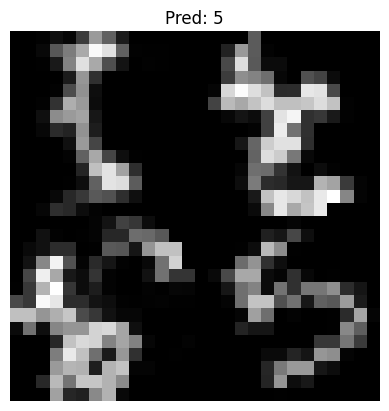

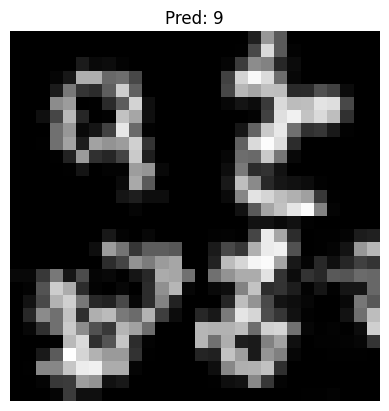

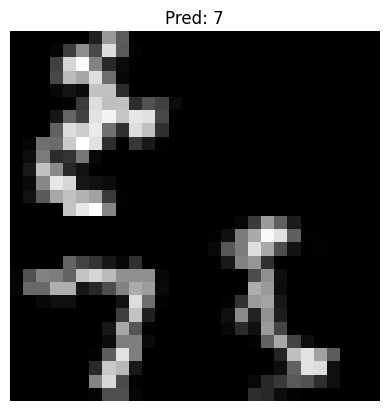

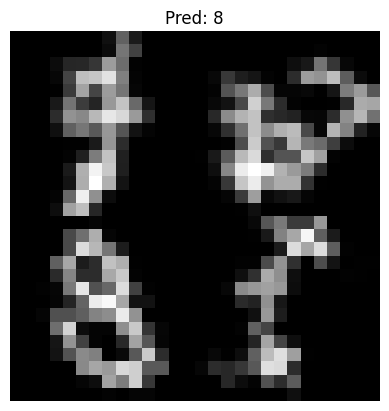

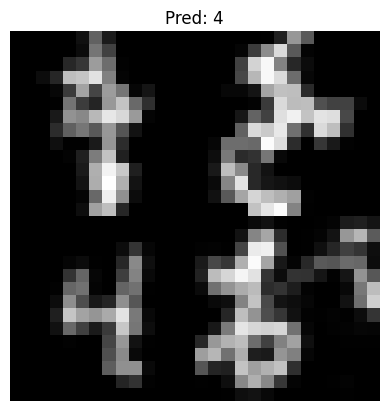

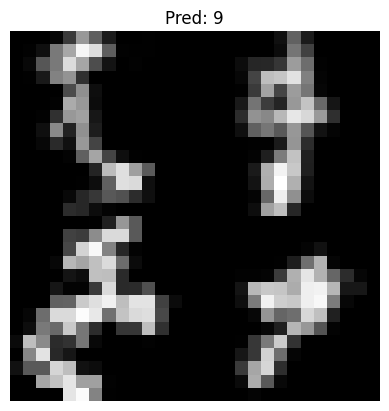

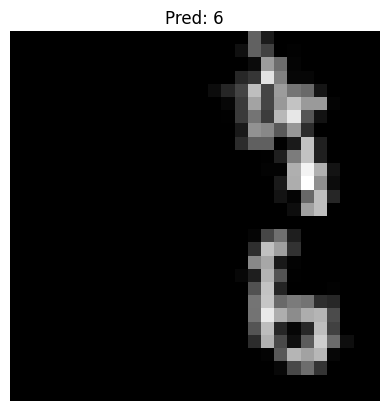

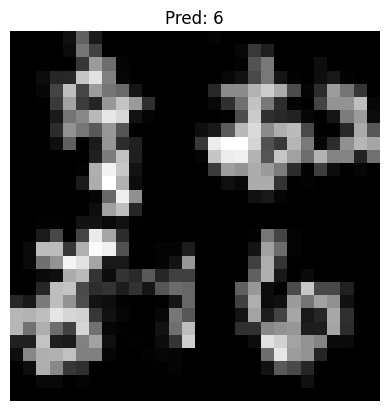

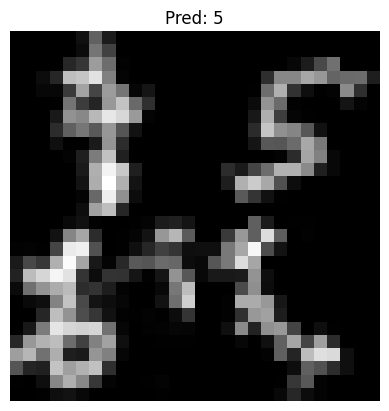

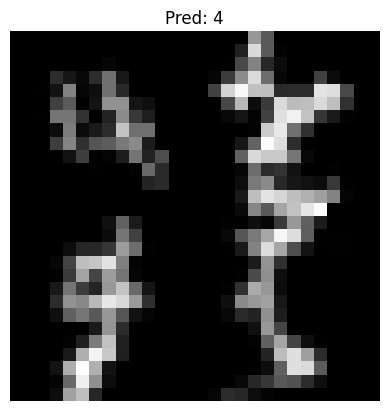

In [ ]:
import matplotlib.pyplot as plt

# Display first few images and their labels
for i in range(10):  # Display first 5 images
    plt.imshow(test_images[i+15].reshape((28, 28)), cmap='gray')  # Adjust cmap if needed
    plt.title(f"Pred: {predictions[i+15]}")
    plt.axis("off")
    plt.show()

(functions to get code in pdf form)

In [ ]:
!jupyter nbconvert --to pdf  "/content/drive/My Drive/Colab Notebooks/ECSE551/ECSE551Assignment2.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/ECSE551/ECSE551Assignment2.ipynb to pdf
[NbConvertApp] Support files will be in ECSE551Assignment2_files/
[NbConvertApp] Making directory ./ECSE551Assignment2_files
[NbConvertApp] Writing 180220 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 429466 bytes to /content/drive/My Drive/Colab Notebooks/ECSE551/ECSE551Assignment2.pdf
